In [1]:
import numpy as np
import random
import pandas as pd 

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import math,time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

import yfinance as yf

import scipy.stats as stats
from scipy.stats import pearsonr
import itertools
import math
import random
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
start_data='2010-01-04'
end_data='2023-01-13'

lst=['GIS']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


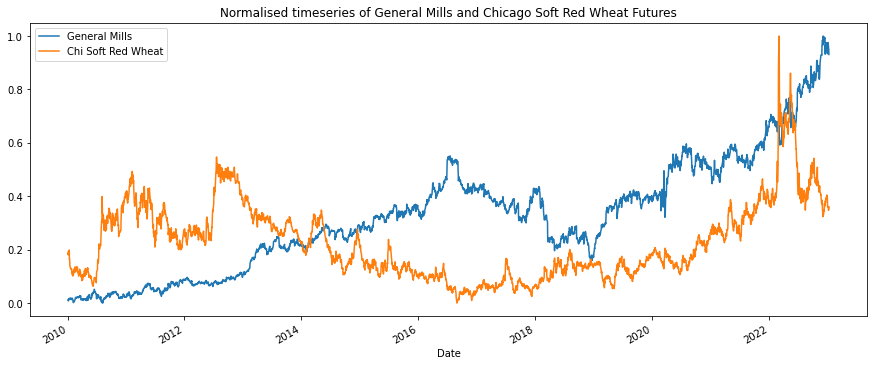

In [3]:
Asset1 = yf.download('GIS', start=start_data, end=end_data)
Asset1['Adj Close Norm']=(Asset1['Adj Close']-Asset1['Adj Close'].min())/(Asset1['Adj Close'].max()-Asset1['Adj Close'].min())
Asset1['Adj Close Norm'].plot(figsize=(15,6),label='General Mills')
Asset2 = yf.download('ZW=F', start=start_data, end=end_data)
Asset2['Adj Close Norm']=(Asset2['Adj Close']-Asset2['Adj Close'].min())/(Asset2['Adj Close'].max()-Asset2['Adj Close'].min())
Asset2['Adj Close Norm'].plot(figsize=(15,6),label='Chi Soft Red Wheat')
plt.title("Normalised timeseries of General Mills and Chicago Soft Red Wheat Futures")
plt.legend()
plt.show()

In [4]:
spread=np.abs(Asset1['Adj Close']-Asset2['Adj Close'])
dates = pd.date_range(start_data,end_data,freq='D')
df1=pd.DataFrame(index=dates)
spread_df=df1.join(spread)
spread_df.head()

,Adj Close
2010-01-04,534.773441
2010-01-05,530.237324
2010-01-06,544.351221
2010-01-07,534.482460
2010-01-08,545.421732


In [5]:
spread_df_norm=spread_df.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
spread_df_norm['Adj Close'] = scaler.fit_transform(spread_df_norm['Adj Close'].values.reshape(-1,1))
spread_df_norm

,Adj Close
2010-01-04,-0.563445
2010-01-05,-0.572045
2010-01-06,-0.545287
2010-01-07,-0.563997
2010-01-08,-0.543257
...,...
2023-01-09,-0.332060
2023-01-10,-0.350773
2023-01-11,-0.333520
2023-01-12,-0.325614


In [6]:
def data(asset, look_back):
    asset = asset
    data = []
    
    #All combinations of data given look back value
    for i in range(len(asset) - look_back): 
        data.append(asset[i: i + look_back])
    
    data = np.array(data);
    test_len = int(np.round(0.15*data.shape[0]))
    train_val_len = data.shape[0] - (test_len)
    val_len = int(np.round(0.25*train_val_len))
    train_len= data.shape[0] - (val_len)-test_len

    x_train = data[:train_len,:-1,:]
    y_train = data[:train_len,-1,:]
    
    x_val = data[train_len:train_len+val_len,:-1,:]
    y_val = data[train_len:train_len+val_len,-1,:]
    
    x_test = data[train_len+val_len:,:-1]
    y_test = data[train_len+val_len:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [7]:
look_back = 2 # choose sequence length
x_train, y_train,x_val,y_val, x_test, y_test = data(spread_df_norm, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_val.shape = ',x_val.shape)
print('y_val.shape = ',y_val.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3032, 1, 1)
y_train.shape =  (3032, 1)
x_val.shape =  (1011, 1, 1)
y_val.shape =  (1011, 1)
x_test.shape =  (713, 1, 1)
y_test.shape =  (713, 1)


In [8]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_val = torch.from_numpy(x_val).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_val = torch.from_numpy(y_val).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [9]:
y_train.size(),x_train.size(),y_val.size(),x_val.size(),y_test.size(),x_test.size()

(torch.Size([3032, 1]),
 torch.Size([3032, 1, 1]),
 torch.Size([1011, 1]),
 torch.Size([1011, 1, 1]),
 torch.Size([713, 1]),
 torch.Size([713, 1, 1]))

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim,stateful):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() #make hidden state 0
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach())) #detach so can do truncated backprop 
        out = self.fc(out[:, -1, :]) 
        return out

In [11]:
input_dim = 1
hidden_dim = 10
num_layers = 5
output_dim = 1

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers,stateful=True)
loss = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 10, num_layers=5, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)


In [13]:
num_epochs =1000
mse_train=[]
mse_val=[]
hist = np.zeros(num_epochs)
seq_dim =look_back-1  
for t in range(num_epochs):
    y_train_prediction = model(x_train) #forward pass 

    loss_train = loss(y_train_prediction, y_train)
    mse_train.append(loss_train.item())
    if t % 1000 == 0 and t !=0:
        print("Epoch", t, "Train MSE: ", loss_train.item())
    
    hist[t] = loss_train.item()
    optimiser.zero_grad()
    loss_train.backward() #backward pass
    optimiser.step() #update parameters

In [14]:
y_val_prediction=model(x_val)
y_test_prediction = model(x_test)

y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_val_prediction = scaler.inverse_transform(y_val_prediction.detach().numpy())
y_val = scaler.inverse_transform(y_val.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

#root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train RMSE Score:',trainScore)
valScore = math.sqrt(mean_squared_error(y_val[:,0], y_val_prediction[:,0]))
print('Val RMSE Score:',valScore)
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test RMSE Score:', testScore)

Train RMSE Score: 12.345422404506989
Val RMSE Score: 9.199986698306875
Test RMSE Score: 74.72914960563415


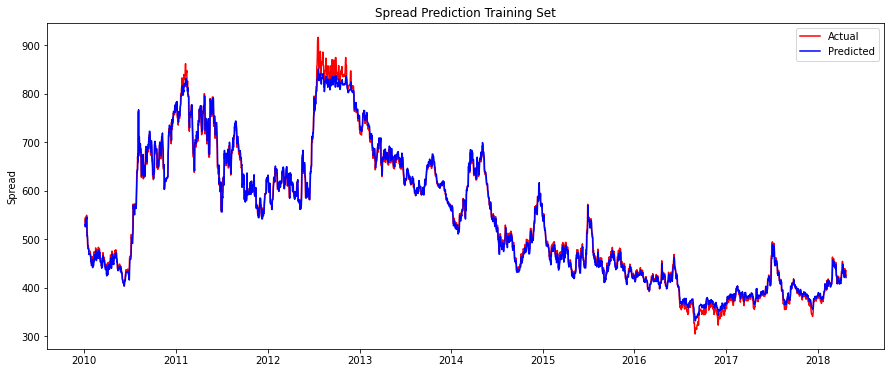

In [15]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[:len(y_train)].index, y_train, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[:len(y_train)].index, y_train_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Training Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

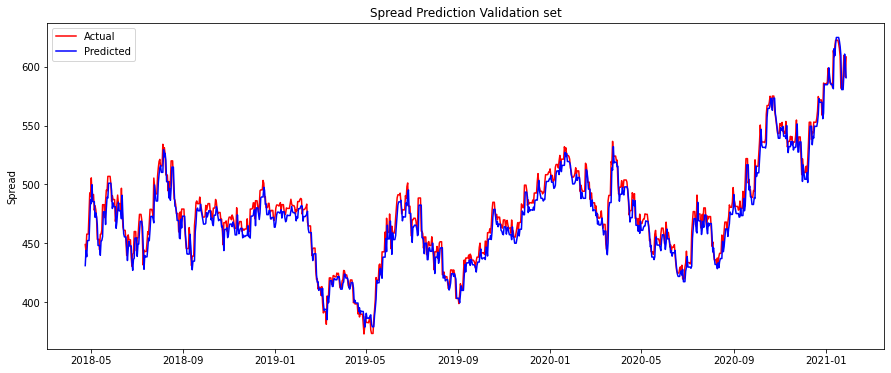

In [16]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(y_train):len(y_train)+len(y_val)].index, y_val_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Validation set')
plt.ylabel('Spread')
plt.legend()
plt.show()

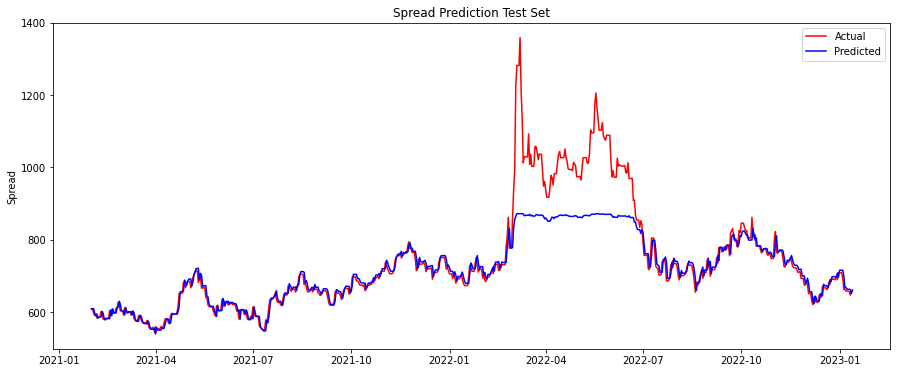

In [17]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test, color = 'red', label = 'Actual')
axes.plot(spread_df_norm[len(spread_df_norm)-len(y_test):].index, y_test_prediction, color = 'blue', label = 'Predicted')
plt.title('Spread Prediction Test Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [18]:
ydf=spread_df[0:len(y_train)].fillna(method='ffill')
y_perc_change=ydf.pct_change().fillna(method='ffill')['Adj Close']
negchange=[]
poschange=[]
for i in range(0,len(y_perc_change)):
    if y_perc_change[i]>= 0:
        poschange.append(y_perc_change[i])
    else:
        negchange.append(y_perc_change[i])

In [19]:
import math
from numpy import nan
negchange=[item for item in negchange if not(math.isnan(item)) == True]
poschange=[item for item in poschange if not(math.isnan(item)) == True]


In [20]:
pospercentile=np.percentile(poschange, np.arange(0, 100, 20))
negpercentile=np.percentile(negchange, np.arange(0, 100, 20))
top_quintile_threshold = pospercentile[-1]
bottom_quintile_threshold = negpercentile[1]

pospercentile=np.percentile(poschange, np.arange(0, 100, 10))
negpercentile=np.percentile(negchange, np.arange(0, 100, 10))
top_decile_threshold = pospercentile[-1]
bottom_decile_threshold = negpercentile[1]

In [21]:
print('Top quintile threshold:',top_quintile_threshold,'Bottom quintile threshold:',bottom_quintile_threshold)

Top quintile threshold: 0.016202432279684813 Bottom quintile threshold: -0.023683219122894728


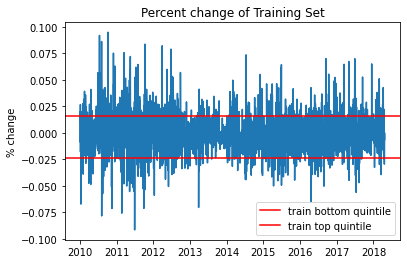

In [57]:
plt.plot(y_perc_change)
plt.axhline(y = bottom_quintile_threshold, color = 'r', linestyle = '-',label='train bottom quintile')
plt.axhline(y = top_quintile_threshold, color = 'r', linestyle = '-',label='train top quintile')
plt.title('Percent change of Training Set')
plt.ylabel('% change')
plt.legend()
plt.show()

In [23]:
#Percent change between forecast spread at time and actual spread 
def percentage_change(col1,col2):
    return ((col2 - col1) / col1) 
perc_change=[]
for i in range(0,len(y_test)-2):
    
    percΔ=percentage_change(y_test[i],y_test_prediction[i+2])
    perc_change.append(percΔ)
perc_change.append(0)
    
perc=np.array(perc_change,dtype=object)

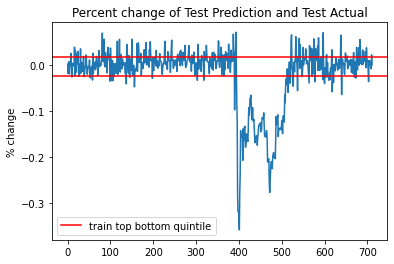

In [54]:
plt.plot(perc)
plt.axhline(y = bottom_quintile_threshold, color = 'r', linestyle = '-',label='train top bottom quintile')
plt.axhline(y = top_quintile_threshold, color = 'r', linestyle = '-')
plt.title('Percent change of Test Prediction and Test Actual')
plt.ylabel('% change')
plt.legend()
plt.show()

In [25]:
below_quint=[]
above_quint=[]

for i in range(0,len(perc)):
    if perc[i]<= bottom_quintile_threshold:
        below_quint.append(i)
    elif perc[i] >= top_quintile_threshold:
        above_quint.append(i)


In [36]:
x_quint_long=[]
y_quint_long=[]
x_quint_short=[]
y_quint_short=[]

test_spread=spread_df[len(y_train)+len(y_val)+2:]
for i in range(0,len(below_quint)):
    x_quint_long.append(test_spread.index[below_quint[i]])
    y_quint_long.append(test_spread['Adj Close'][below_quint[i]])

for i in range(0,len(above_quint)):
    x_quint_short.append(test_spread.index[above_quint[i]])
    y_quint_short.append(test_spread['Adj Close'][above_quint[i]])


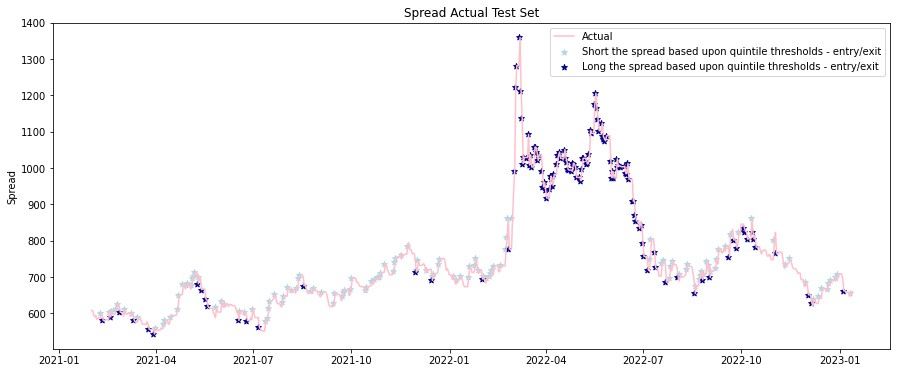

In [55]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(spread_df_norm[len(y_train)+len(y_val)+2:].index, y_test, color = 'pink', label = 'Actual')
plt.scatter(x_quint_short, y_quint_short, marker="*", color="lightblue",label='Short the spread based upon quintile thresholds - entry/exit')
plt.scatter(x_quint_long, y_quint_long, marker="*", color="darkblue",label='Long the spread based upon quintile thresholds - entry/exit')

plt.title('Spread Actual Test Set')
plt.ylabel('Spread')
plt.legend()
plt.show()

In [39]:
dates1 = pd.date_range(start_data,end_data,freq='D')
df1=pd.DataFrame(index=dates1)
A1=df1.join(Asset1)
A1=A1.fillna(method='ffill')

dates2 = pd.date_range(start_data,end_data,freq='D')
df2=pd.DataFrame(index=dates2)
A2=df2.join(Asset2)
A2=A2.fillna(method='ffill')

In [41]:
ratio=np.abs(A1['Adj Close']/A2['Adj Close'])
test_ratio=ratio[len(y_train)+len(y_val)+2:]

In [42]:
x_r_quint_short=[]
y_r_quint_short=[]
x_r_quint_long=[]
y_r_quint_long=[]

for i in range(0,len(below_quint)):
    x_r_quint_long.append(test_ratio.index[below_quint[i]])
    y_r_quint_long.append(test_ratio[below_quint[i]])

for i in range(0,len(above_quint)):
    x_r_quint_short.append(test_ratio.index[above_quint[i]])
    y_r_quint_short.append(test_ratio[above_quint[i]])


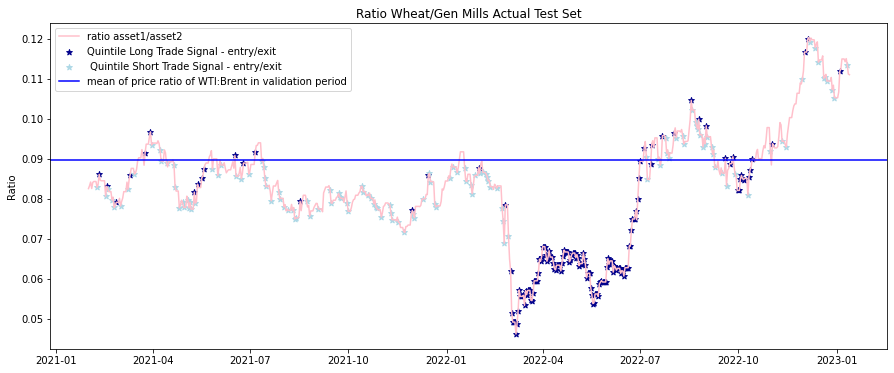

In [56]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(test_ratio.index, test_ratio, color = 'pink', label = 'ratio asset1/asset2')


plt.scatter(x_r_quint_long, y_r_quint_long, marker="*", color="darkblue",label='Quintile Long Trade Signal - entry/exit')
plt.scatter(x_r_quint_short, y_r_quint_short, marker="*", color="lightblue",label=' Quintile Short Trade Signal - entry/exit')

plt.axhline(y = ratio[len(y_train):len(y_train)+len(y_val)].mean(), color = 'b', linestyle = '-',label='mean of price ratio of WTI:Brent in validation period')
plt.title('Ratio Wheat/Gen Mills Actual Test Set')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [44]:
#Quintile
trade=0
#asset 1 overvalued when ratio above mean -> sell asset 1 long asset 2
#asset 2 overvalue when ratio below mean -> sell asset2 long asset2
#calculate positions
positions_quint=pd.DataFrame(index=ratio[len(y_train)+len(y_val)+2:].index, columns = ['Gen Mills','CSRW','l/s spread'])
position_open=False
for date in range(0,len(perc)):  
    #if no position is open
    if position_open==False:
        if perc[date] <= bottom_quintile_threshold:
            position_open = True
            trade+=1
            if test_ratio[date] >= test_ratio.mean():
                positions_quint.loc[test_ratio.index[date]] = [1,-1,'long spread']
            else:
                positions_quint.loc[test_ratio.index[date]] = [-1,1,'long spread']
        elif perc[date]>=top_quintile_threshold:
            position_open = True
            trade+=1
            if test_ratio[date] >= test_ratio.mean():
                positions_quint.loc[test_ratio.index[date]] = [-1,1,'short spread']
            else:
                positions_quint.loc[test_ratio.index[date]] = [1,-1,'short spread']
             
        else:
            position_open = False
            if test_ratio[date] >= test_ratio.mean():
                positions_quint.loc[test_ratio.index[date]] = [0,0,'no change']
            else:
                positions_quint.loc[test_ratio.index[date]] = [0,0,'no change']
    

# if position is open            
    elif position_open == True:
        if perc[date] <= bottom_quintile_threshold:
            position_open= True
            if test_ratio[date] >= test_ratio.mean():
                positions_quint.loc[test_ratio.index[date]] = [1,-1,'no change']
            else:
                positions_quint.loc[test_ratio.index[date]] = [-1,1,'no change']
        
        elif perc[date]>= top_quintile_threshold:
            position_open= True
            if test_ratio[date] >= test_ratio.mean():
                positions_quint.loc[test_ratio.index[date]] = [-1,1,'no change']
            else:
                positions_quint.loc[test_ratio.index[date]] = [1,-1,'no change']
        else: 
            position_open=False
            trade+=1
            if test_ratio[date] >= test_ratio.mean():
                positions_quint.loc[test_ratio.index[date]] = [0,0,'close trade']
            else:
                positions_quint.loc[test_ratio.index[date]] = [0,0,'close trade'] 

        

In [45]:
#Check number of trades made (used when calculating fees/commisions)
trade_quint=trade
trade_quint

230

In [49]:
A1['log_ret'] = np.log(A1['Adj Close']) - np.log(A1['Adj Close'].shift(1))
logret_asset1=A1[len(y_train)+len(y_val)+2:]

A2['log_ret'] = np.log(A2['Adj Close']) - np.log(A2['Adj Close'].shift(1))
logret_asset2=A2[len(y_train)+len(y_val)+2:]

p_quint=positions_quint.join(logret_asset1)


In [50]:
algo_ret_quint = (p_quint['Gen Mills']*logret_asset1['log_ret'].shift()
                  +p_quint['CSRW']*logret_asset2['log_ret'].shift())


## Quintile threshold method performed better on validation set so that's what we will use going forward

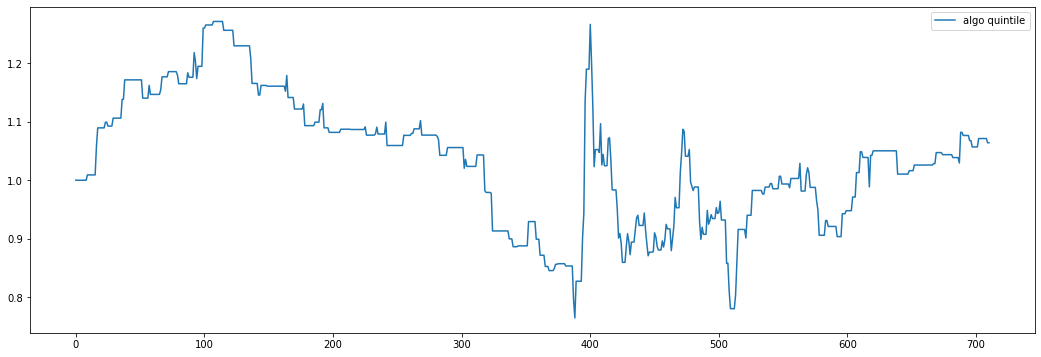

In [51]:
algo_ret_quint=algo_ret_quint.dropna()
returns_quint=[]
for i in range(0,len(algo_ret_quint)):
    returns_quint.append(np.exp(algo_ret_quint[i])-1)
    
plt.figure(figsize=(18,6))
plt.plot(np.nancumprod(np.array(returns_quint)+1), label='algo quintile')
plt.show()

In [52]:
def calculate_metrics(cumret):
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    
    return total_return, apr, sharpe, maxDD

## Comparison of decile quintile algo

In [53]:
metrics = pd.DataFrame(index=[ 'Quintile Algo'], columns=['Total return', 'APR', 'Sharpe', 'Max Drawdown'])
metrics.loc['Quintile Algo'] = calculate_metrics(np.nancumprod(np.array(returns_quint)+1))

metrics

,Total return,APR,Sharpe,Max Drawdown
Quintile Algo,0.064007,0.022233,0.217552,-0.398481
